In [21]:
import random
import time
def generate_cities(num_cities):
    cities = []
    for _ in range(num_cities):
        x = random.randint(-100, 100)
        y = random.randint(-100, 100)
        z = random.randint(0, 50)
        cities.append((x, y, z))
    return cities

# Example: Generate 5 cities
cities = generate_cities(9)
print("Generated cities:", cities)


Generated cities: [(38, 34, 46), (15, -85, 21), (40, -15, 27), (-64, 52, 21), (-32, 17, 40), (83, -93, 29), (58, -57, 35), (57, -33, 15), (74, 25, 31)]


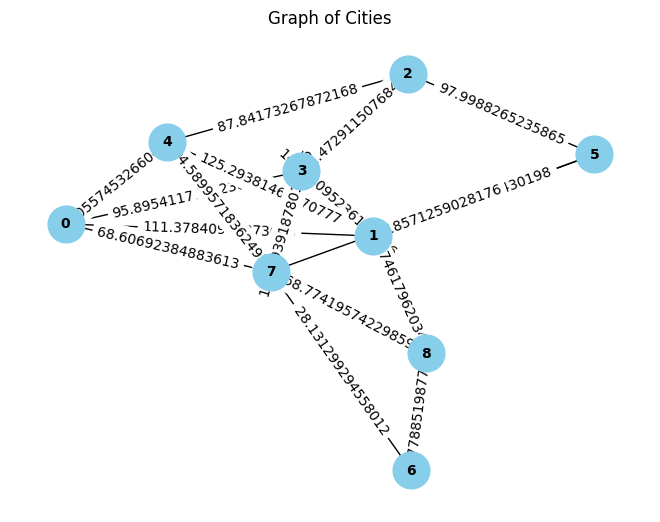

In [22]:
import math
import networkx as nx
import matplotlib.pyplot as plt

def calculate_distance(city1, city2):
    x1, y1, z1 = city1
    x2, y2, z2 = city2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

def create_graph(cities, connections_percentage=0.6, symmetrical=True):
    num_cities = len(cities)
    graph = {i: {} for i in range(num_cities)}
    
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            if random.random() < connections_percentage:
                cost = calculate_distance(cities[i], cities[j])
                if symmetrical:
                    # Adjust cost for asymmetrical scenario
                    cost *= 1.1 if cities[i][2] < cities[j][2] else 0.9
                graph[i][j] = cost
                graph[j][i] = cost
    
    return graph

# Tworzenie grafu
graph = create_graph(cities, connections_percentage=0.6, symmetrical=True)

# Rysowanie grafu
G = nx.Graph()
for i, neighbors in graph.items():
    for j, cost in neighbors.items():
        G.add_edge(i, j, weight=cost)

pos = nx.spring_layout(G)  # Ustalenie pozycji węzłów
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graph of Cities")
plt.show()


In [23]:
def tsp_bfs(graph, start):
    queue = [(start, [start], 0)]
    num_cities = len(graph)
    shortest_path = None
    min_cost = float('inf')

    while queue:
        current_city, path, cost = queue.pop(0)

        if len(path) == num_cities and start in graph[current_city]:
            # Return to starting city
            cost += graph[current_city][start]
            if cost < min_cost:
                shortest_path = path + [start]
                min_cost = cost
        else:
            for neighbor, edge_cost in graph[current_city].items():
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_cost = cost + edge_cost
                    queue.append((neighbor, new_path, new_cost))

    return shortest_path, min_cost

def tsp_dfs(graph, start):
    stack = [(start, [start], 0)]
    num_cities = len(graph)
    shortest_path = None
    min_cost = float('inf')

    while stack:
        current_city, path, cost = stack.pop()

        if len(path) == num_cities and start in graph[current_city]:
            # Return to starting city
            cost += graph[current_city][start]
            if cost < min_cost:
                shortest_path = path + [start]
                min_cost = cost
        else:
            for neighbor, edge_cost in graph[current_city].items():
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_cost = cost + edge_cost
                    stack.append((neighbor, new_path, new_cost))

    return shortest_path, min_cost

# Example: Solve TSP using BFS and DFS
start_city = 0
shortest_path_bfs, min_cost_bfs = tsp_bfs(graph, start_city)
shortest_path_dfs, min_cost_dfs = tsp_dfs(graph, start_city)


In [24]:
from queue import PriorityQueue

def admissible_heuristic(graph, current_city, remaining_cities):
    """
    Calculate the admissible heuristic for A* algorithm
    by calculating the minimum spanning tree of the remaining cities.
    """
    from heapq import heappop, heappush

    if not remaining_cities:
        return 0

    mst_cost = 0
    visited = set()
    edges = []
    start_city = next(iter(remaining_cities))

    visited.add(start_city)
    for neighbor, cost in graph[start_city].items():
        if neighbor in remaining_cities:
            heappush(edges, (cost, start_city, neighbor))

    while edges and len(visited) < len(remaining_cities):
        cost, from_city, to_city = heappop(edges)
        if to_city not in visited:
            visited.add(to_city)
            mst_cost += cost
            for neighbor, cost in graph[to_city].items():
                if neighbor not in visited and neighbor in remaining_cities:
                    heappush(edges, (cost, to_city, neighbor))

    return mst_cost

def average_inadmissible_heuristic(graph, current_city, remaining_cities):
    """
    Calculate the average inadmissible heuristic for A* algorithm
    by estimating the average distance to the remaining cities.
    """
    total_distance = 0
    for city in remaining_cities:
        total_distance += graph[current_city][city]
    return total_distance / len(remaining_cities) if remaining_cities else 0


def tsp_a_star(graph, start_city, admissible=True):
    """
    Solve TSP using A* algorithm with either admissible or inadmissible heuristics.
    """
    priority_queue = PriorityQueue()
    num_cities = len(graph)
    heuristic_func = admissible_heuristic if admissible else average_inadmissible_heuristic
    initial_state = (0 + heuristic_func(graph, start_city, set(graph.keys()) - {start_city}), 0, start_city, [start_city])
    priority_queue.put(initial_state)
    best_cost = float('inf')
    best_path = None

    while not priority_queue.empty():
        _, cost, current_city, path = priority_queue.get()

        if len(path) == num_cities:
            # Ensure there's a connection back to the start city
            if start_city in graph[current_city]:
                cost += graph[current_city][start_city]
                if cost < best_cost:
                    best_cost = cost
                    best_path = path + [start_city]
            continue

        for neighbor, edge_cost in graph[current_city].items():
            if neighbor not in path:
                new_path = path + [neighbor]
                new_cost = cost + edge_cost
                remaining_cities = set(graph.keys()) - set(new_path)
                new_heuristic = heuristic_func(graph, neighbor, remaining_cities)
                priority_queue.put((new_cost + new_heuristic, new_cost, neighbor, new_path))

    return best_path, best_cost

# Porównanie wyników
shortest_path_bfs, min_cost_bfs = tsp_bfs(graph, start_city)
print("Shortest path using BFS:", shortest_path_bfs, "Cost:", min_cost_bfs)

# Wyświetlanie drzewa stanów dla DFS
shortest_path_dfs, min_cost_dfs = tsp_dfs(graph, start_city)
print("Shortest path using DFS:", shortest_path_dfs, "Cost:", min_cost_dfs)
# A* z heurystyką niedopuszczalną
shortest_path_astar_inadmissible, min_cost_astar_inadmissible = tsp_a_star(graph, start_city)
print("Shortest path using A* with inadmissible heuristic:", shortest_path_astar_inadmissible, "Cost:", min_cost_astar_inadmissible)

# A* z heurystyką dopuszczalną
shortest_path_astar_admissible, min_cost_astar_admissible = tsp_a_star(graph, start_city)
print("Shortest path using A* with admissible heuristic:", shortest_path_astar_admissible, "Cost:", min_cost_astar_admissible)



Shortest path using BFS: [0, 4, 7, 6, 8, 1, 5, 2, 3, 0] Cost: 781.9964433671026
Shortest path using DFS: [0, 4, 7, 6, 8, 1, 5, 2, 3, 0] Cost: 781.9964433671026
Shortest path using A* with inadmissible heuristic: [0, 4, 7, 6, 8, 1, 5, 2, 3, 0] Cost: 781.9964433671026
Shortest path using A* with admissible heuristic: [0, 4, 7, 6, 8, 1, 5, 2, 3, 0] Cost: 781.9964433671026


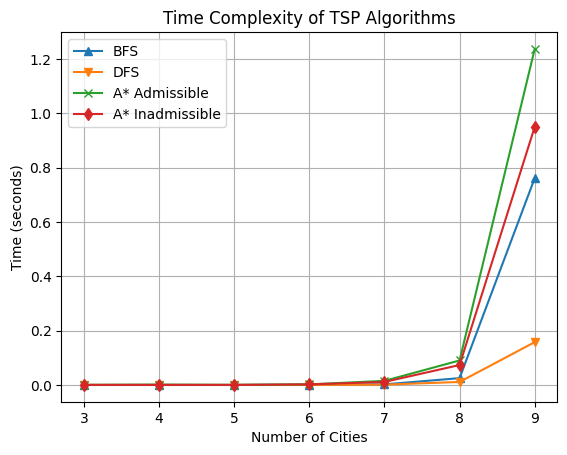

In [25]:
# Measure execution time for each algorithm
num_cities_range = range(3, 10)
times_bfs = []
times_dfs = []
times_astar_admissible = []
times_astar_inadmissible = []

for num_cities in num_cities_range:
    cities = generate_cities(num_cities)
    graph = create_graph(cities, connections_percentage=1.0, symmetrical=True)
    
    start_city = 0


    
    start_time = time.time()
    tsp_bfs(graph, start_city)
    end_time = time.time()
    times_bfs.append(end_time - start_time)
    
    start_time = time.time()
    tsp_dfs(graph, start_city)
    end_time = time.time()
    times_dfs.append(end_time - start_time)
    
    start_time = time.time()
    tsp_a_star(graph, start_city, admissible=True)
    end_time = time.time()
    times_astar_admissible.append(end_time - start_time)
    
    start_time = time.time()
    tsp_a_star(graph, start_city, admissible=False)
    end_time = time.time()
    times_astar_inadmissible.append(end_time - start_time)


plt.plot(num_cities_range, times_bfs, marker='^', label='BFS')
plt.plot(num_cities_range, times_dfs, marker='v', label='DFS')
plt.plot(num_cities_range, times_astar_admissible, marker='x', label='A* Admissible')
plt.plot(num_cities_range, times_astar_inadmissible, marker='d', label='A* Inadmissible')
plt.xlabel('Number of Cities')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of TSP Algorithms')
plt.legend()
plt.grid(True)
plt.show()